# 데이터 불러오기

데이터를 불러온 뒤 어떠한 feature이 있는지 살펴봅니다.

In [44]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')
print(data_train.shape)
data_train.head(1).transpose()

(3000, 24)


,0
id,1
Gender,Female
Customer Type,disloyal Customer
Age,22
Type of Travel,Business travel
Class,Eco
Flight Distance,1599
Seat comfort,3
Departure/Arrival time convenient,0
Food and drink,3


# 데이터 훑어보기

데이콘에서 주어진 기본 EDA중 data histogram과 feature destribution을 사용하여 데이터를 전반적으로 파악합니다.

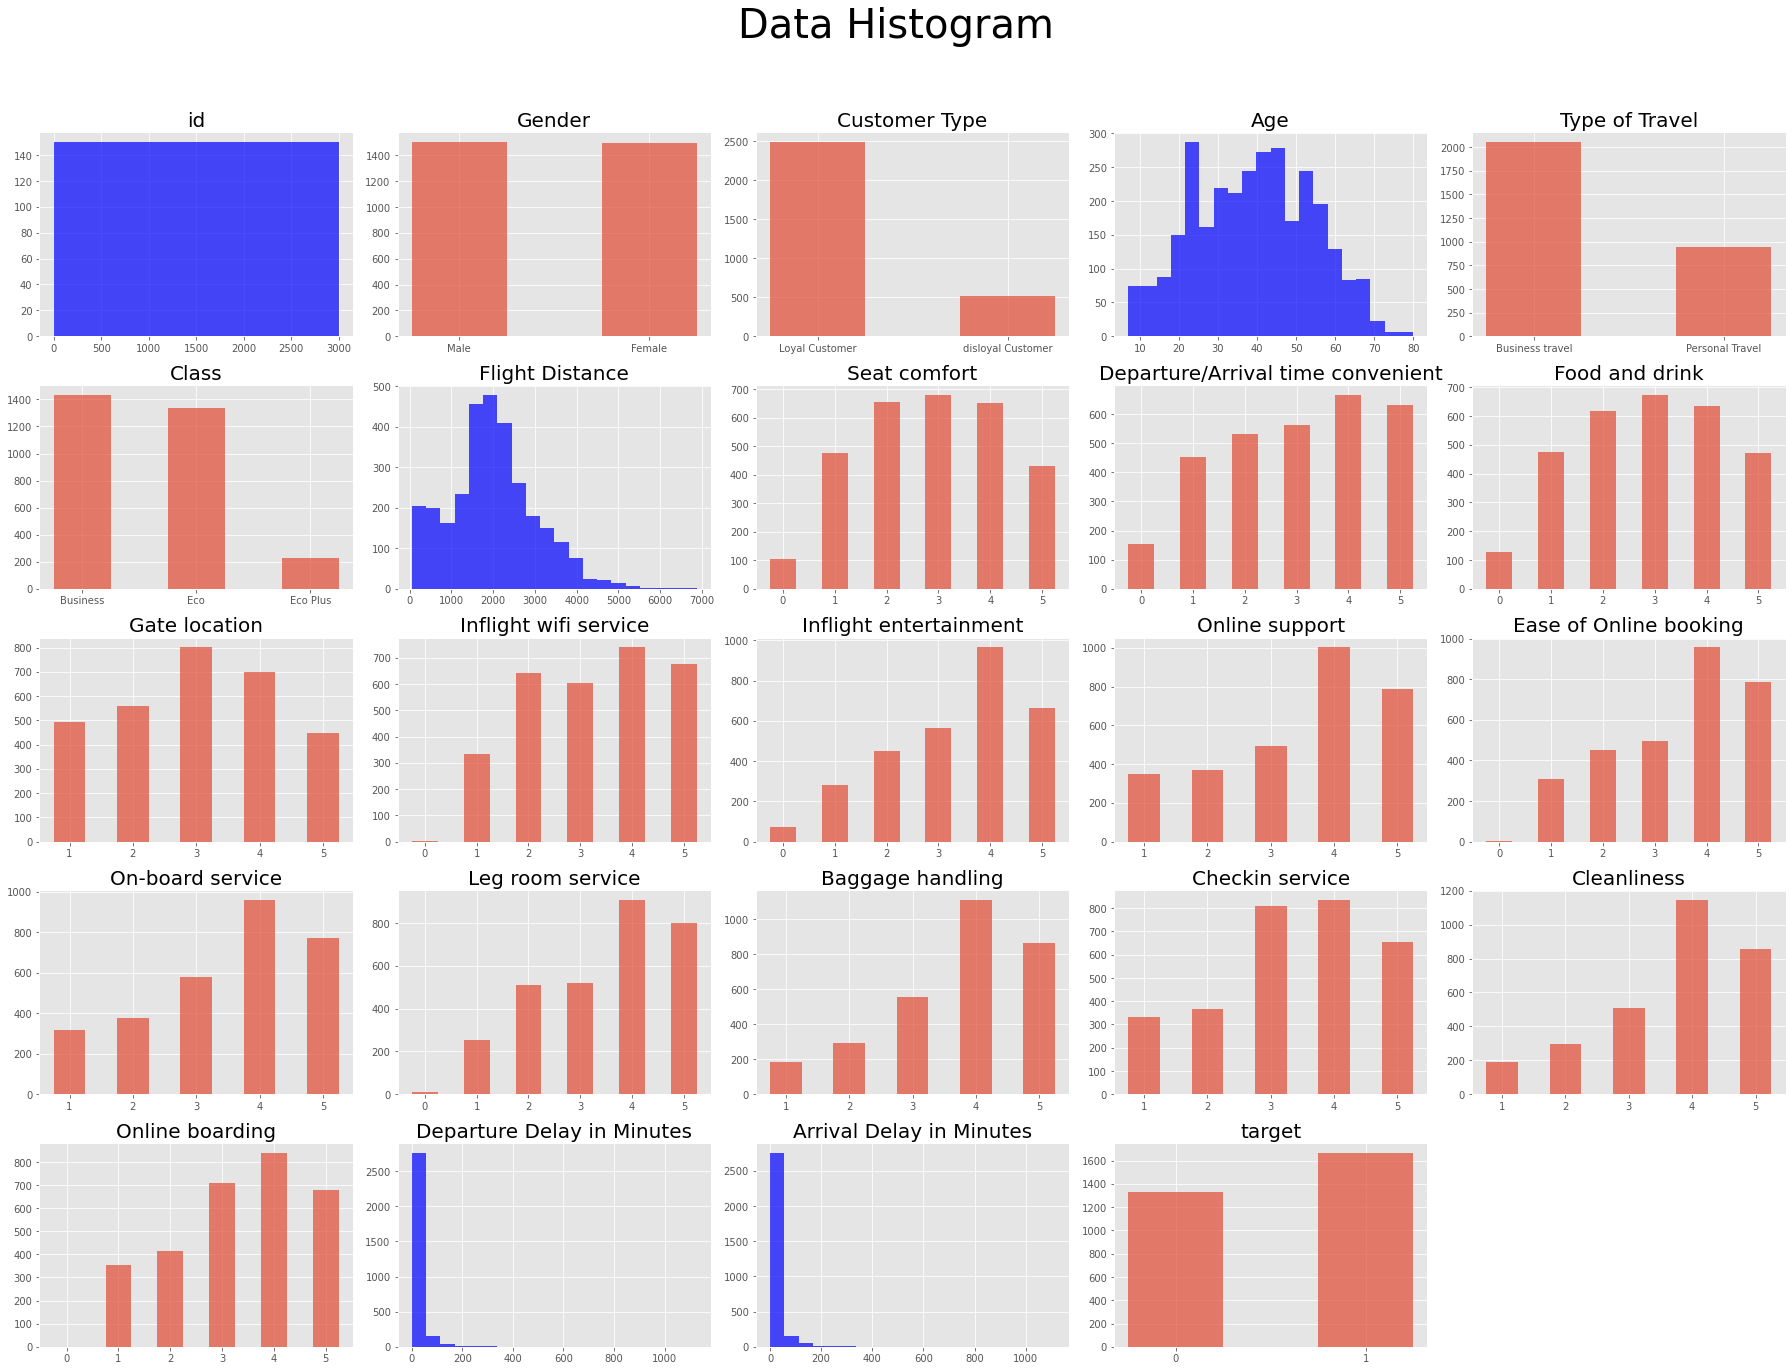

In [45]:
plt.style.use("ggplot")

# 히스토그램 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,20))
plt.suptitle("Data Histogram", fontsize=40)

# id는 제외하고 시각화합니다.
cols = data_train.columns
for i in range(len(cols)):
    plt.subplot(5,5,i+1)
    plt.title(cols[i], fontsize=20)
    if len(data_train[cols[i]].unique()) > 20:
        plt.hist(data_train[cols[i]], bins=20, color='b', alpha=0.7)
    else:
        temp = data_train[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

저는 데이터를 훑어볼때 두가지를 우선적으로 살펴봅니다

- 데이터의 분포가 상대적으로 매우 적은지 -> 매우 적다면 범주를 합치거나 하는 등의 변환이 필요함
- 데이터의 분포가 극단적으로 치우쳐져 있는지 -> log변환 등의 방법을 통해 정규화해주는 작업이 필요함

우선 이 그래프를 훑어본 뒤 주목해야할 점은 두가지가 있습니다.

첫번째로 Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes 등의 그래프가 왼쪽으로 치우쳐져 있다는 점,

두번째로 Leg room service 등 1~5를 가진 feature중에서 0값의 분포가 매우 적다는 점입니다.

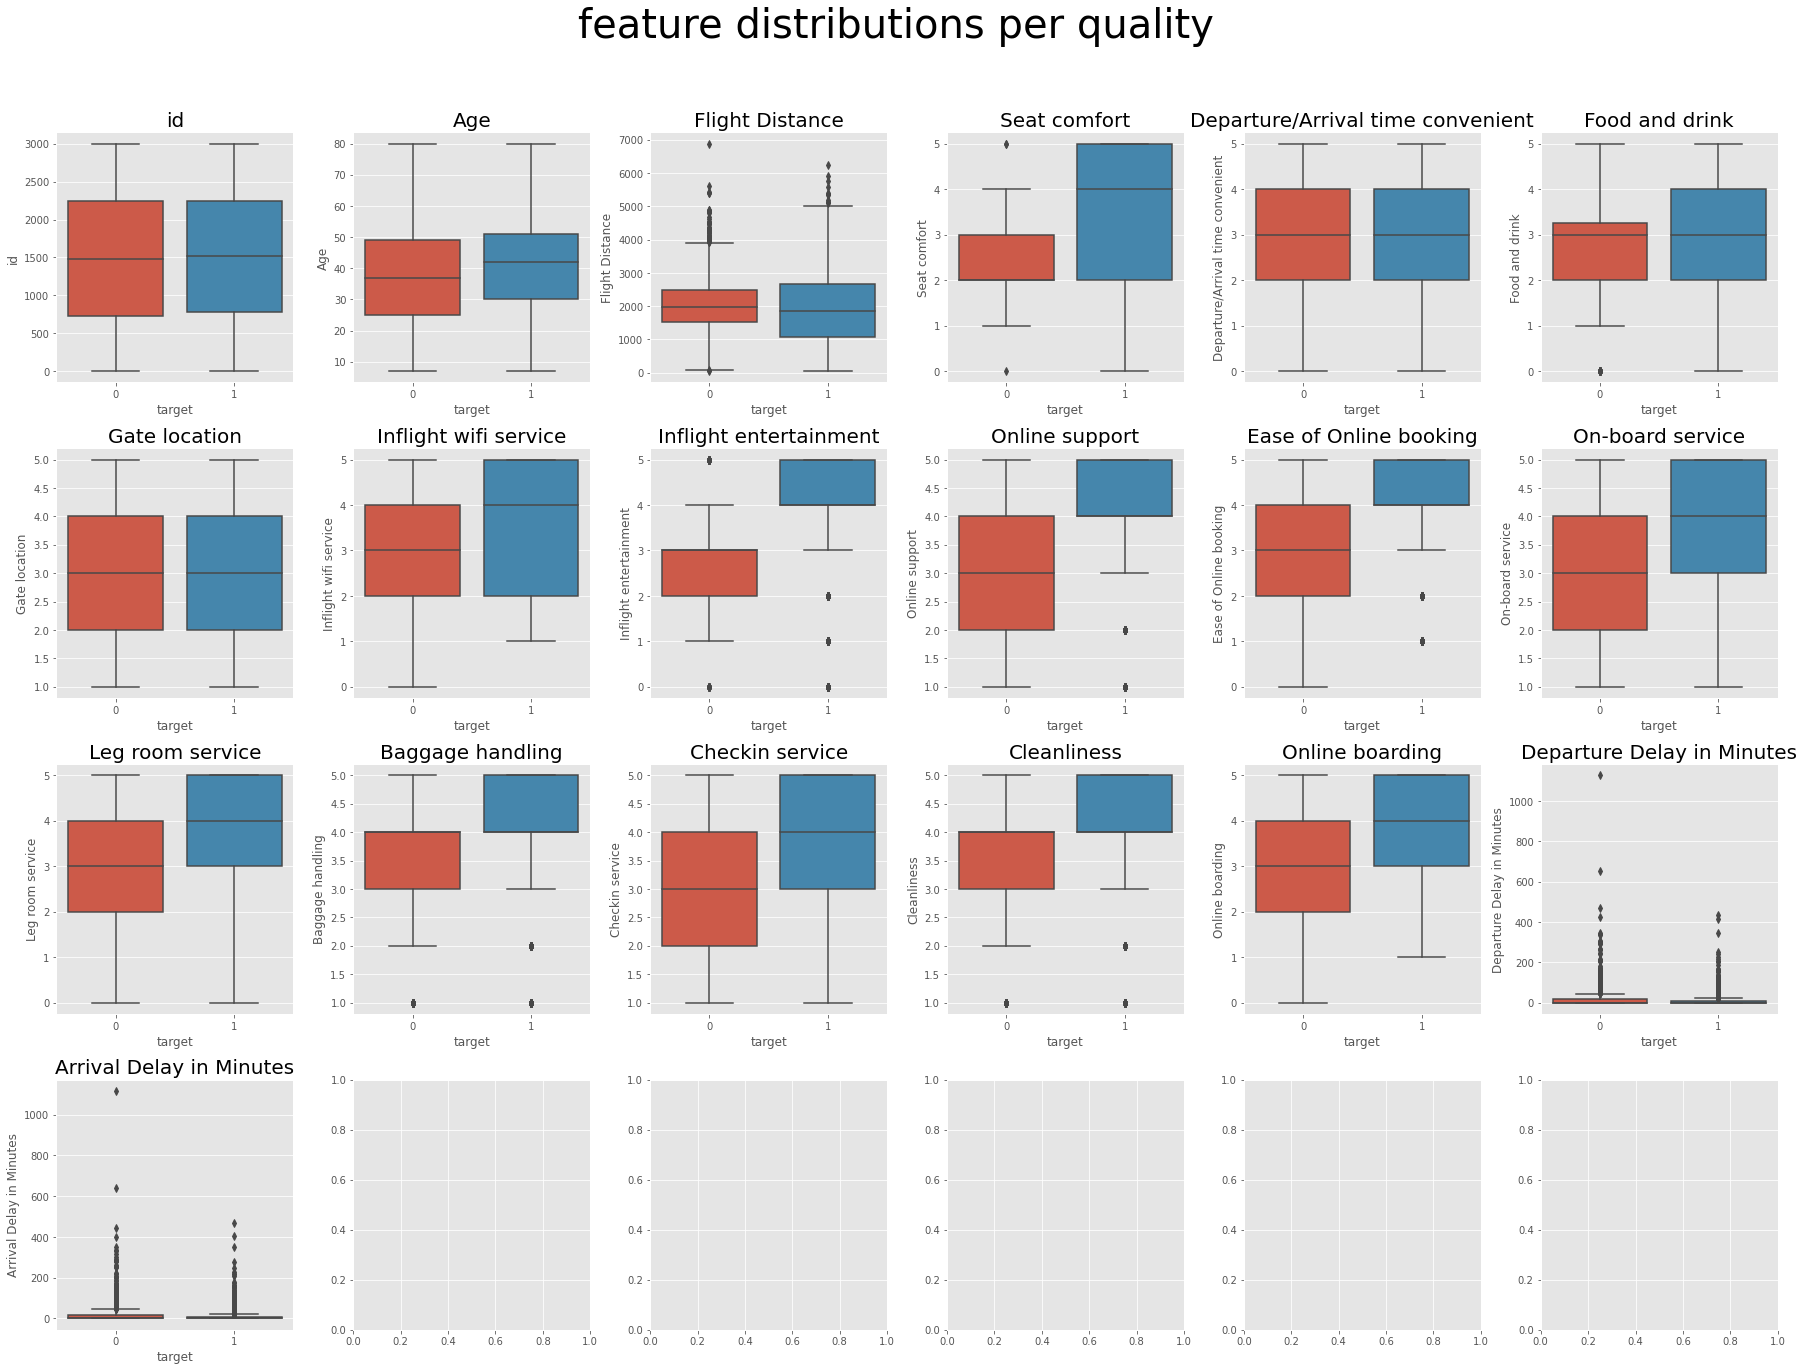

In [46]:
# 수치형 데이터 분리
numeric_feature = data_train.columns[(data_train.dtypes=='int64') | (data_train.dtypes=='float')]
num_data = data_train[numeric_feature]

# 박스플롯
fig, axes = plt.subplots(4, 6, figsize=(25, 20))

fig.suptitle('feature distributions per quality', fontsize= 40)
for ax, col in zip(axes.flat, num_data.columns[:-1]):
    sns.boxplot(x= 'target', y= col, ax=ax, data=num_data)
    ax.set_title(col, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

여기서도 Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes 등의 박스플롯이 고르지 않습니다.

# 데이터 분류하기

## 데이터의 속성에 따라서 numeric, ordinal, categorical로 나누어 분류합니다.

numeric feature = 숫자형 자료 -> Flight Distance 등의 숫자형 데이터.

ordinal feature = 순서형 자료 -> Seat comfort 등 (매우만족 > 만족 > 보통 > 불만족 > 매우불만족)의 설문순서를 가진 데이터.

categorical feature = 범주형 자료 -> 남자 / 여자 등 범주별로 나눠진 데이터.

In [47]:
numeric_feature = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_feature = ['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 
           'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 
           'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
categorical_feature = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

# 데이터 훑어보기

### feature / target 그래프로 target과 feature의 관계를 파악합니다

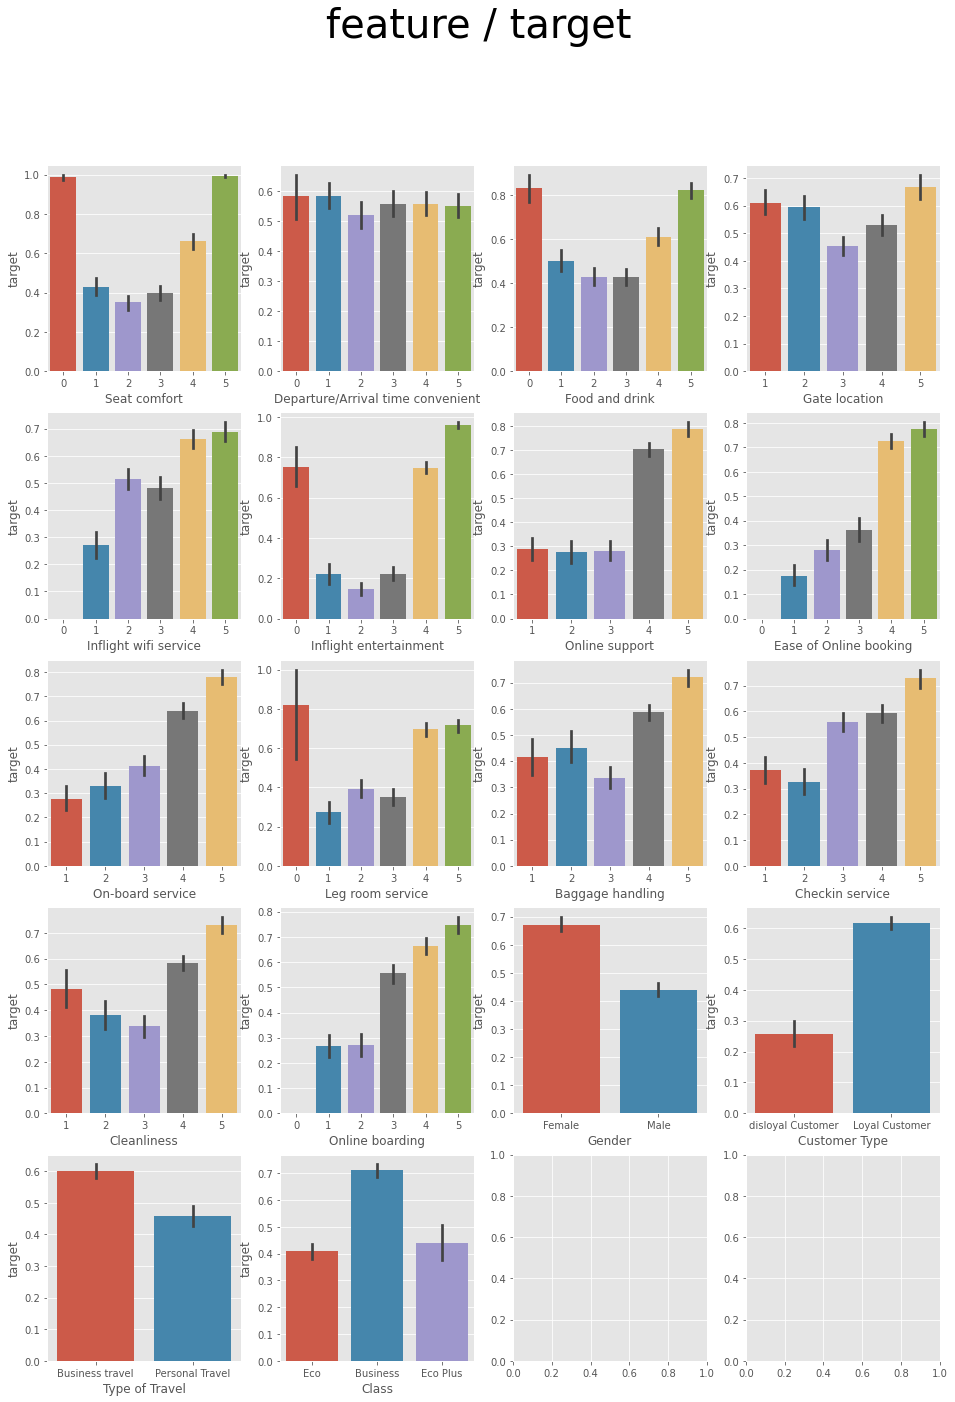

In [48]:
fig, ax = plt.subplots(5, 4, figsize = (16, 22))

plt.suptitle("feature / target", fontsize=40)

feature = ordinal_feature + categorical_feature

xvalue = 0
yvalue = 0

for xstr in feature:
    sns.barplot(x = xstr, y = 'target', data = data_train, ax = ax[yvalue][xvalue])
        
    if xvalue == 3:
        xvalue = 0
        yvalue += 1
    else:
        xvalue += 1

## 여기서 주목해야할 점은 0에서 5로 이루어진 ordinal feature 데이터에서 0의 의미입니다. 

0에서 5의 범위를 우리가 만족도라고 생각할 경우 0은 매우나쁨, 5는 매우좋음이라고 생각할 수 있습니다. 이때 그래프를 참고하면 5에 가까울수록 전체적인 만족도가 높았다는것을 의미하며 우리가 구해야 할 target, 즉 만족을 하여 1값이 나올 확률이 높다는 것입니다. 

그렇다면 0에 가까워질수록 target이 1이 될 확률이 낮아지고, 5에 가까워질수록 target이 1이 될 확률이 높아져야 합니다. 하지만 그래프에서 1에서 5에 해당하는 부분은 예상처럼 값이 증가할수록 target의 확률이 높아지는 양상을 보이고 있지만, **0의 경우에는 위에서 확인한것처럼 설문한 데이터의 수가 매우 적을뿐더러 어떨때는 만족도가 5일때보다 target의 확률이 높은 모습을 보여주고 있습니다.(편차도 매우 심합니다)**

그렇다면 1~5의 값을 매우나쁨 나쁨 보통 좋음 매우좋음 / 이 다섯개로 분류할 경우 0값이 의미하는 것이 무엇인가에 대한 의문에 도달합니다. **여기서 저는 0이 누락된 결측치나, 설문하지 않은 값을 모두 Nan 대신 0이라는 값으로 채워넣었다는 결론에 도달하게 되었습니다.**

결론적으로 0을 데이터의 양이 적다고 1에 합치거나, 0~5로 label encoding을 하여 순서를 부여할 경우 학습에 안좋은 영향을 끼칠 수 있습니다.

따라서 만약 0값이 포함된 ordinal feature로 학습을 진행한다면 label encoding보다는 one-hot encoding을 이용하여 0에 의미를 부여하지 않는 것이 중요해 보입니다.

# 데이터 정제하기

데이터 정제에서 진행한 작업은 크게 세가지입니다.
- 데이터 훑어보기 단계에서 얻은 insight를 바탕으로 데이터 정제하기
- 새로운 feature 만들기
- 데이터 제거하기

## 데이터 훑어보기 단계에서 얻은 insight를 바탕으로 데이터 정제하기
### 1.Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes 그래프가 왼쪽으로 치우쳐져 있다는 점

log 변환을 이용하여 치우쳐진 정도를 줄여보겠습니다 (치우쳐진 정도 = skewness, 왜도)

In [49]:
for xstr in numeric_feature:
    print(xstr, "Scew :", data_train[xstr].skew())

Age Scew : 0.0010456925943488839
Flight Distance Scew : 0.4509930169224059
Departure Delay in Minutes Scew : 9.190139679910239
Arrival Delay in Minutes Scew : 8.887761727831762


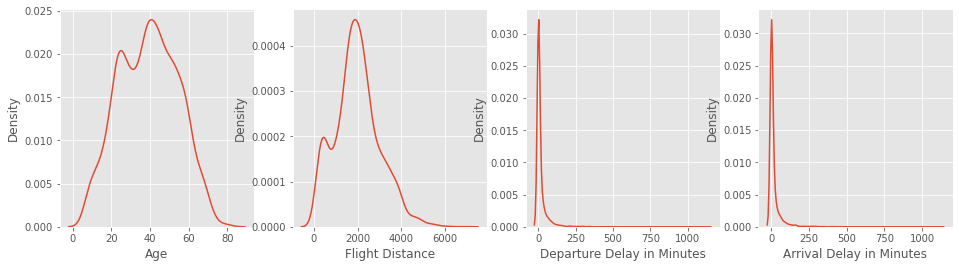

In [50]:
fig, ax = plt.subplots(1, 4, figsize = (16, 4))

for xint in range(4):
    sns.kdeplot(x = numeric_feature[xint], data = data_train, ax = ax[xint])

Flight Distance는 왜도가 심하지 않기 때문에, Departure Delay in Minutes, Arrival Delay in Minutes만 log변환하겠습니다

In [51]:
#log 변환 실행

data_train['Departure Delay in Minutes'] = np.log1p(data_train['Departure Delay in Minutes'])
data_train['Arrival Delay in Minutes'] = np.log1p(data_train['Arrival Delay in Minutes'])

#test 데이터에도 변환 실행

data_test['Departure Delay in Minutes'] = np.log1p(data_test['Departure Delay in Minutes'])
data_test['Arrival Delay in Minutes'] = np.log1p(data_test['Arrival Delay in Minutes'])

In [52]:
for xstr in numeric_feature:
    print(xstr, "Scew :", data_train[xstr].skew())

Age Scew : 0.0010456925943488839
Flight Distance Scew : 0.4509930169224059
Departure Delay in Minutes Scew : 0.9302111175258293
Arrival Delay in Minutes Scew : 0.8979015577156512


모든 skew가 1 이하로 내려간 모습입니다

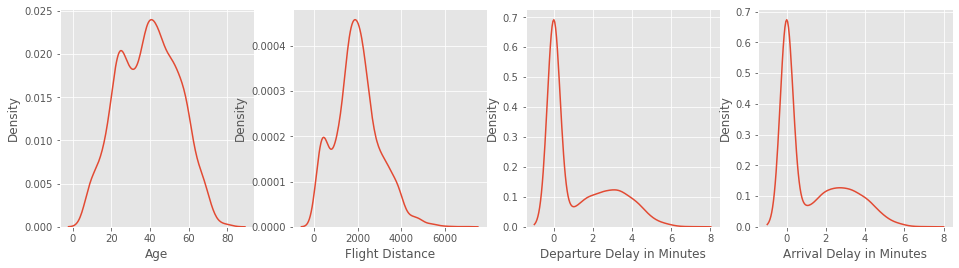

In [53]:
fig, ax = plt.subplots(1, 4, figsize = (16, 4))

for xint in range(4):
    sns.kdeplot(x = numeric_feature[xint], data = data_train, ax = ax[xint])

### 2.Leg room service 등 1~5를 가진 feature중에서 0값은 Null값, 결측치이다.

여기서 결측치라는것을 인지하고, 대치하지 않는 방법이 있으나 저는 결측치를 대치하여 최대한 복원해보는 과정을 선택했습니다.

결측치가 적다면 결측치를 대치하여 데이터 복구를 시도해보고, 결측치가 많다면 0인 그대로 놔둔후 one-hot encoding을 이용하겠습니다.

1~5값을 가진 범주형 데이터 결측치를 대치하기 위해서 딥러닝 기반의 datawig라는 라이브러리를 사용하였습니다.

datawig 말고도 다양한 데이터 결측치 대치 방법을 통해 데이터 복구를 시도해 볼 수 있습니다.

In [54]:
print("Train data missing value")
for feature in ordinal_feature:
    if len(data_train[data_train[feature] == 0]) > 0:
        print(feature, len(data_train[data_train[feature] == 0]))

print("=======================")
        
print("Test data missing value")
for feature in ordinal_feature:
    if len(data_test[data_test[feature] == 0]) > 0:
        print(feature, len(data_test[data_test[feature] == 0]))

Train data missing value
Seat comfort 106
Departure/Arrival time convenient 154
Food and drink 129
Inflight wifi service 2
Inflight entertainment 73
Ease of Online booking 1
Leg room service 11
Online boarding 1
Test data missing value
Seat comfort 64
Departure/Arrival time convenient 90
Food and drink 80
Inflight wifi service 1
Inflight entertainment 39
Leg room service 10


**여기서 수가 20개 이하로 적은 친구들만 datawig를 이용하여 대치한 결과가 가장 좋았습니다.**

#### online booking and boarding
우선 train data에만 Ease of Online Booking과 Online boarding의 결측치가 1개 있기 때문에 이 부분은 train data만 간단하게 수정해줍니다.

In [55]:
corr_matrix = data_train.corr()
corr_matrix["Online boarding"].sort_values(ascending=False)[:5]

Online boarding           1.000000
Ease of Online booking    0.684511
Online support            0.675139
Inflight wifi service     0.632049
Inflight entertainment    0.353772
Name: Online boarding, dtype: float64

Ease of Online Booking과 Online boarding은 Online support와 상관관계가 높고, 상식적으로도 둘 모두가 Online support라는 범주 안에 해당한다고 생각하기 때문에 Online support값으로 대치해줍니다.

In [56]:
data_train["Ease of Online booking"][data_train["Ease of Online booking"] == 0] = 3
data_train["Online boarding"][data_train["Online boarding"] == 0] = 3

### datawig를 통해 대치하기 위해 0값을 np.nan값으로 바꿔준다

In [57]:
for i in range(len(data_train)):
    for feature in ordinal_feature:
        if data_train[feature].iloc[i] == 0:
            data_train[feature].iloc[i] = np.nan

for i in range(len(data_test)):
    for feature in ordinal_feature:
        if data_test[feature].iloc[i] == 0:
            data_test[feature].iloc[i] = np.nan

#### Inflight wifi service
상관관계가 높은 3개의 feature를 선정하고 datawig를 이용하여 학습시킨뒤 train과 test셋의 결측치를 대치합니다.

In [58]:
corr_matrix = data_train.corr()
corr_matrix["Inflight wifi service"].sort_values(ascending=False)[:5]

Inflight wifi service     1.000000
Online boarding           0.630754
Ease of Online booking    0.602117
Online support            0.562900
Inflight entertainment    0.290907
Name: Inflight wifi service, dtype: float64

In [59]:
import datawig

target_feature = "Inflight wifi service"

imputer = datawig.SimpleImputer(input_columns=['Online boarding', 'Ease of Online booking', 'Online support'],
                                output_column=target_feature)
imputer.fit(train_df=data_train, num_epochs=50)

null_train = data_train[data_train[target_feature].isnull()]
null_imputed = imputer.predict(null_train)
imputed_train = pd.DataFrame(null_imputed)

n = 0
for i in range(len(data_train)):
    if np.isnan(data_train[target_feature].iloc[i]) == True:
        data_train[target_feature].iloc[i] = int(round(imputed_train[target_feature+"_imputed"].iloc[n]))
        n += 1
        
null_train = data_test[data_test[target_feature].isnull()]
null_imputed = imputer.predict(null_train)
imputed_train = pd.DataFrame(null_imputed)

n = 0
for i in range(len(data_test)):
    if np.isnan(data_test[target_feature].iloc[i]) == True:
        data_test[target_feature].iloc[i] = int(round(imputed_train[target_feature+"_imputed"].iloc[n]))
        n += 1

#### Leg room service
상관관계가 높은 3개의 feature를 선정하고 datawig를 이용하여 학습시킨뒤 train과 test셋의 결측치를 대치합니다.

In [60]:
corr_matrix = data_train.corr()
corr_matrix["Inflight wifi service"].sort_values(ascending=False)[:5]

Inflight wifi service     1.000000
Online boarding           0.630527
Ease of Online booking    0.602079
Online support            0.562687
Inflight entertainment    0.290797
Name: Inflight wifi service, dtype: float64

In [61]:
import datawig

target_feature = "Leg room service"

imputer = datawig.SimpleImputer(input_columns=['Baggage handling', 'On-board service', 'Cleanliness'],
                                output_column=target_feature)
imputer.fit(train_df=data_train, num_epochs=50)

null_train = data_train[data_train[target_feature].isnull()]
null_imputed = imputer.predict(null_train)
imputed_train = pd.DataFrame(null_imputed)

n = 0
for i in range(len(data_train)):
    if np.isnan(data_train[target_feature].iloc[i]) == True:
        data_train[target_feature].iloc[i] = int(round(imputed_train[target_feature+"_imputed"].iloc[n]))
        n += 1
        
null_train = data_test[data_test[target_feature].isnull()]
null_imputed = imputer.predict(null_train)
imputed_train = pd.DataFrame(null_imputed)

n = 0
for i in range(len(data_test)):
    if np.isnan(data_test[target_feature].iloc[i]) == True:
        data_test[target_feature].iloc[i] = int(round(imputed_train[target_feature+"_imputed"].iloc[n]))
        n += 1

In [62]:
for feature in ordinal_feature:
    if data_train[feature].isnull().sum() > 0:
        print(feature, data_train[feature].isnull().sum())
print("================")
for feature in ordinal_feature:
    if data_test[feature].isnull().sum() > 0:
        print(feature, data_test[feature].isnull().sum())

Seat comfort 106
Departure/Arrival time convenient 154
Food and drink 129
Inflight entertainment 73
Seat comfort 64
Departure/Arrival time convenient 90
Food and drink 80
Inflight entertainment 39


나머지는 건드리지 않습니다. 하지만 이 4개의 feature는 많은 결측치를 가지고 있기 때문에 될 수 있다면 제거하는게 좋아보입니다.

## 새로운 feature 만들기

새로운 feature, 즉 파생변수를 만드는 것은 많은 도움이 됩니다. 많은 대회들의 상위 커널들을 살펴보면 좋은 파생변수를 통해 모델의 성능을 높이는 경우가 많다고 합니다.

현재까지 저는 새로운 feature의 생성보다 데이터를 대치하는 부분에 많은 신경을 기울였습니다.

Arrival Delay in Minutes는 분으로 된 numeric feature이기 때문에 1분 지연과 지연없음에 대한 차이가 적게 나타납니다. 따라서 조금이라도 시간이 지연되었다면 사람들의 만족도가 크게 떨어졌을거라고 가정하고 지연된 부분이 있는지 / 없는지에 대한 boolean 변수를 하나 추가하여 딜레이가 있었는지 / 없었는지에 대한 feature를 생성하였습니다.

In [63]:
data_train['Delayed'] = (data_train['Departure Delay in Minutes'] 
                         + data_train['Arrival Delay in Minutes']).apply(lambda x : 0 if x > 0 else 1)
data_test['Delayed'] = (data_test['Departure Delay in Minutes'] 
                         + data_test['Arrival Delay in Minutes']).apply(lambda x : 0 if x > 0 else 1)

## 데이터 제거하기

https://dacon.io/competitions/official/235871/codeshare/4468?page=1&dtype=recent 성지코딩님의 다중공선성 부분을 참고하였습니다.

총 4가지 데이터를 제거하였습니다.

- id - 학습에 관련없음
- Departure Delay in Minutes - Arrival Delay in Minutes과의 다중 공선성과 target과의 낮은 상관계수
- Food and drink - Seat comfort와의 다중 공선성과 많은 결측치
- Departure/Arrival time convenient - 많은 결측치 및 target과의 낮은 상관계수

In [64]:
corr_matrix = data_train.corr()
corr_matrix["target"].sort_values(ascending=False)

target                               1.000000
Inflight entertainment               0.601695
Ease of Online booking               0.447450
Online support                       0.411944
Seat comfort                         0.372013
On-board service                     0.359699
Online boarding                      0.350895
Leg room service                     0.320374
Checkin service                      0.248975
Inflight wifi service                0.241221
Cleanliness                          0.234848
Baggage handling                     0.232302
Food and drink                       0.219507
Age                                  0.107226
Delayed                              0.097188
id                                   0.007544
Gate location                        0.003213
Departure/Arrival time convenient   -0.005230
Flight Distance                     -0.052059
Departure Delay in Minutes          -0.105554
Arrival Delay in Minutes            -0.142003
Name: target, dtype: float64

In [65]:
data_train = data_train.drop(['Food and drink', 'Departure/Arrival time convenient', 'Departure Delay in Minutes', 'id'], axis = 1)
data_test = data_test.drop(['Food and drink', 'Departure/Arrival time convenient', 'Departure Delay in Minutes', 'id'], axis = 1)

# 모델 학습하기
### 빠르게 다양한 결과를 시도해보기 위해 pycaret을 사용하여 모델을 선정하고 학습했습니다.

가장 성능이 높은 LGBM, CATBOOST, XGBOOST 3가지를 사용한 soft-voting을 이용하였습니다.

추가적으로 tune_model 등의 하이퍼파라미터 튜닝을 이용하여 성능을 더 끌어올렸습니다.

In [66]:
from pycaret.classification import *
clf1 = setup(data = data_train,
             silent = True,
             target = 'target',
             session_id = 123,
             n_jobs = 7)

,Description,Value
0,session_id,20201809
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(3000, 21)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,15
8,Ordinal Features,False
9,High Cardinality Features,False


In [67]:
best = compare_models(n_select=3, fold = 10) #상위 모델 3개를 선택합니다

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9323,0.9812,0.9453,0.9364,0.9406,0.862,0.8626,1.186
lightgbm,Light Gradient Boosting Machine,0.9319,0.9811,0.9445,0.9366,0.9402,0.8611,0.862,0.116
xgboost,Extreme Gradient Boosting,0.9285,0.9811,0.9436,0.9318,0.9374,0.8542,0.8551,0.409
et,Extra Trees Classifier,0.9214,0.9743,0.9344,0.9281,0.9309,0.8397,0.8405,0.196
gbc,Gradient Boosting Classifier,0.9209,0.9749,0.9327,0.9286,0.9303,0.8389,0.8397,0.113
rf,Random Forest Classifier,0.9166,0.9714,0.9352,0.9198,0.9271,0.8297,0.8307,0.217
lr,Logistic Regression,0.8961,0.9583,0.9041,0.9124,0.9078,0.7889,0.7901,0.612
lda,Linear Discriminant Analysis,0.8938,0.9569,0.9016,0.9107,0.9056,0.7841,0.7853,0.01
ridge,Ridge Classifier,0.8933,0,0.9016,0.9099,0.9052,0.7831,0.7842,0.006
ada,Ada Boost Classifier,0.8852,0.9543,0.8932,0.9035,0.8978,0.7668,0.7681,0.055


In [68]:
blend_3_soft = blend_models(estimator_list=best, method='soft', choose_better = True)
predict_model(blend_3_soft).head(10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9381,0.9922,0.9244,0.9649,0.9442,0.8748,0.8758
1,0.9429,0.9818,0.9328,0.9652,0.9487,0.8842,0.8849
2,0.9381,0.9885,0.9748,0.9206,0.9469,0.8728,0.8749
3,0.9143,0.9744,0.9412,0.9106,0.9256,0.8246,0.8252
4,0.9429,0.9849,0.9748,0.928,0.9508,0.8827,0.8843
5,0.9238,0.9825,0.9328,0.9328,0.9328,0.8449,0.8449
6,0.9381,0.9759,0.958,0.9344,0.9461,0.8735,0.8738
7,0.9524,0.9824,0.958,0.958,0.958,0.903,0.903
8,0.919,0.9815,0.9328,0.925,0.9289,0.835,0.835
9,0.9187,0.9822,0.9322,0.9244,0.9283,0.8344,0.8344


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9267,0.9825,0.9499,0.9155,0.9324,0.8525,0.8532


,Age,Flight Distance,Inflight wifi service,Leg room service,Arrival Delay in Minutes,Gender_Female,Customer Type_Loyal Customer,Type of Travel_Business travel,Class_Business,Class_Eco,...,Cleanliness_5,Online boarding_1,Online boarding_2,Online boarding_3,Online boarding_4,Online boarding_5,Delayed_0,target,Label,Score
0,47.0,974.0,1.0,4.0,0.000000,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0,0.5912
1,38.0,1236.0,5.0,4.0,2.890372,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,1,0.9998
2,26.0,2065.0,3.0,4.0,2.890372,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.7497
3,25.0,2934.0,4.0,4.0,0.000000,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,1,0.9970
4,14.0,3119.0,4.0,5.0,2.708050,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1,0.9521
5,43.0,4113.0,4.0,2.0,0.000000,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0.8488
6,26.0,2233.0,4.0,5.0,4.127134,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,0.9059
7,37.0,4188.0,5.0,4.0,1.791759,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0.9416
8,48.0,2522.0,4.0,5.0,1.945910,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1,1,0.9989
9,36.0,534.0,5.0,1.0,2.397895,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.7950


In [69]:
final_blend_3_soft = finalize_model(blend_3_soft)
prediction = predict_model(final_blend_3_soft, data = data_test)

In [71]:
print(prediction["Label"])

0       1
1       0
2       1
3       1
4       1
       ..
1995    0
1996    1
1997    0
1998    1
1999    1
Name: Label, Length: 2000, dtype: int32


In [72]:
submission = pd.read_csv("./sample_submission.csv")
submission.head()

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [73]:
submission['target'] = prediction['Label']
submission.head()

,id,target
0,1,1
1,2,0
2,3,1
3,4,1
4,5,1


In [74]:
submission.to_csv("flight_predict_test.csv",index=False)